<a href="https://colab.research.google.com/github/Will170393/MSc-Project---Stance-Detection/blob/master/3_msc_project_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [0]:
# libraries for processing data
import numpy as np
import pandas as pd
import re

# libraries for loading files from drive
from google.colab import drive
drive.mount('/content/gdrive')

# libraries for natural language processing
from nltk import FreqDist, word_tokenize
import nltk
nltk.download('punkt')

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score

# neural network libraries
import tensorflow as tf
from keras import regularizers
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.layers import Dropout, Activation
from keras.utils.np_utils import to_categorical

from matplotlib import pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Reading data into panda dataframes and merging Stances and Bodies**

In [0]:
# creates dataframes from reading the stance and body csv files from the google drive, train/test set already split
trainStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_stances.csv')
trainBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_bodies.csv')
testStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_stances.csv')
testBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_bodies.csv')

In [0]:
# merges dataframes for article bodies and article stances, inner merge on the Body ID column that appears in both dataframes
def mergeStances_Bodies(stances, bodies):
  return pd.merge(stances, bodies, how='inner', on='Body ID')

In [0]:
# creates merged training and test dataframes
train = mergeStances_Bodies(trainStances, trainBodies)
test = mergeStances_Bodies(testStances, testBodies)

**Adding bert vectors to dataframe**

In [0]:
# load in bert sentence vectors
bert_train_heads = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_train_heads.npy')
bert_train_bodies = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_train_bodies.npy')
bert_test_heads = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_test_heads.npy')
bert_test_bodies = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_test_bodies.npy')

In [0]:
# method to add sentence vectors to dataframe
def add_vectors_to_df(data, col, array):
  data[col] = pd.Series(array.tolist())

In [0]:
add_vectors_to_df(train, 'Headline_vector', bert_train_heads)
add_vectors_to_df(train, 'articleBody_vector', bert_train_bodies)
add_vectors_to_df(test, 'Headline_vector', bert_test_heads)
add_vectors_to_df(test, 'articleBody_vector', bert_test_bodies)

In [0]:
# method to convert the sentence vectors to numpy arrays
def convert_to_numpy(data, col):
  data[col] = data[col].apply(lambda x: np.array(x))

In [0]:
convert_to_numpy(train, 'Headline_vector')
convert_to_numpy(train, 'articleBody_vector')
convert_to_numpy(test, 'Headline_vector')
convert_to_numpy(test, 'articleBody_vector')

In [0]:
type(train['Headline_vector'][0][0])

numpy.float64

**Shuffling and sampling data**

In [0]:
print(train.Stance.value_counts())

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64


In [0]:
# methods for re-sampling the data
def upsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  minority_class = dataframe[dataframe.Stance == classification]
  samples = len(minority_class)
  
  samples_left = (target_samples - samples)
  
  while (samples_left != 0):
    
    if(samples_left < samples):
      samples = samples_left
  
    minority_class_upsampled = resample(minority_class,
                                        replace = False,
                                        n_samples = samples)
  
    dataframe = dataframe.append(minority_class_upsampled, ignore_index=True)
    
    samples_left -= samples
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

def downsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  majority_class = dataframe[dataframe.Stance == classification]
  
  majority_class_downsampled = resample(majority_class,
                                        replace = False,
                                        n_samples = target_samples)
  
  
  dataframe = dataframe[dataframe.Stance != classification]
  
  dataframe = dataframe.append(majority_class_downsampled, ignore_index=True)
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

**Data Processing**

In [0]:
# mehod for retrieving the sentence vectors
def data_processing(data):
  transformed_data = []
  for index, row in data.iterrows():
    head = row['Headline_vector']
    body = row['articleBody_vector']
    features = np.concatenate((head, body))
    transformed_data.append(features)
  transformed_data = np.array(transformed_data)
  return transformed_data

In [0]:
# method to create cross validation folds
def dataset_folds(dataset, i, k):
  n = len(dataset)
  return dataset[n*(i-1)//k:n*i//k]

In [0]:
def build_model(input_shape):
  # initialise nueral net
  model = Sequential()

  # add layer with input shape as number of dimensions in feature vectors
  model.add(Dense(800, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(input_shape,)))
  model.add(Dropout(0.2, noise_shape=None, seed=None))
  model.add(Dense(4, activation='softmax')) #output softmax activation function
  
  return model

In [0]:
# train and test mlp
def run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, test_df):
  Ytrain = to_categorical(Ytrain, num_classes = 4)
  Ytest = to_categorical(Ytest, num_classes = 4)
  
  model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

  for i in range(1):
    history = model.fit(Xtrain, Ytrain, epochs = 50, validation_split=0.2, shuffle=True)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    test_loss, test_acc = model.evaluate(Xtest, Ytest)
    print(test_loss, test_acc)
    
    Ypred = model.predict(Xtest)
    Ypred_bool = np.argmax(Ypred, axis=1)

    Ytest = test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})

    print(classification_report(Ytest, Ypred_bool))

    print(confusion_matrix(Ytest, Ypred_bool))
    
    return test_acc

In [0]:
# combine all data in the dataframe
all_data = train.append(test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
W0902 15:10:04.575079 139780163987328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 15:10:04.600822 139780163987328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.

W0902 15:10:04.743480 139780163987328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     11048
           1       0.82      0.69      0.75       305
           2       0.79      0.89      0.84      2644
           3       0.76      0.77      0.77      1080

    accuracy                           0.91     15077
   macro avg       0.83      0.82      0.83     15077
weighted avg       0.92      0.91      0.91     15077

[[10370    13   486   179]
 [   41   209    18    37]
 [  225    13  2361    45]
 [  121    21   105   833]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 14s 288us/step - loss: 1.5054 - acc: 0.5158 - val_loss: 1.1001 - val_acc: 0.6240
Epoch 2/50
48000/48000 [==============================] - 10s 206us/step - loss: 1.1308 - acc: 0.5942 - val_loss: 1.0352 - val_acc: 0.6583
Epoch 3/50
48000/48000 [==============================] - 10s 198us/step - loss: 1.0574 - acc: 0.6336 - val_loss: 0.9941 - val_a

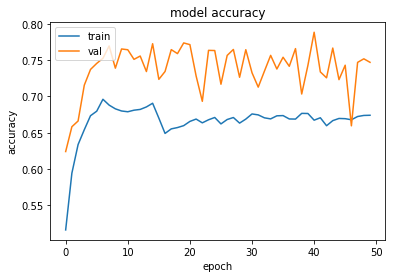

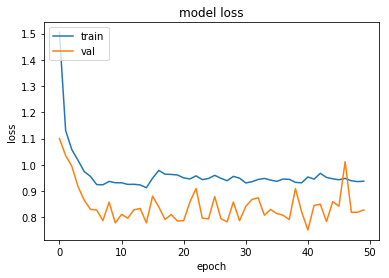

15077/15077 [==============================] - 1s 57us/step
0.8855337625932905 0.6827618226457387
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     11048
           1       0.17      0.90      0.29       305
           2       0.51      0.76      0.61      2644
           3       0.29      0.58      0.39      1080

    accuracy                           0.68     15077
   macro avg       0.49      0.73      0.52     15077
weighted avg       0.84      0.68      0.73     15077

[[7384  736 1737 1191]
 [   0  275   17   13]
 [  21  284 2006  333]
 [   8  288  155  629]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.93      0.94     11018
           1       0.76      0.63      0.69       322
           2       0.76      0.88      0.82      2635
           3       0.72      0.72      0.72      1102

    accuracy                           0.90     15077
   macro avg       0.80      0.79      0.79     15077
weighted avg       0.90      0.90      0.90     15077

[[10243    19   549   207]
 [   46   204    33    39]
 [  245    23  2309    58]
 [  146    23   136   797]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 10s 209us/step - loss: 1.5154 - acc: 0.5044 - val_loss: 1.1318 - val_acc: 0.5812
Epoch 2/50
48000/48000 [==============================] - 9s 197us/step - loss: 1.1425 - acc: 0.5764 - val_loss: 1.0962 - val_acc: 0.6120
Epoch 3/50
48000/48000 [==============================] - 9s 196us/step - loss: 1.0722 - acc: 0.6182 - val_loss: 0.9997 - val_acc

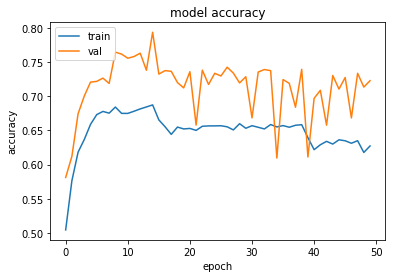

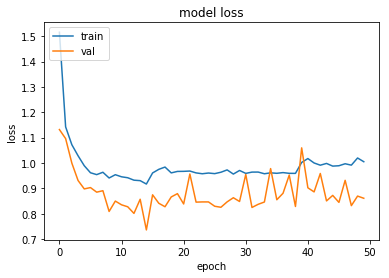

15077/15077 [==============================] - 1s 57us/step
0.9073728320689846 0.613915235128328
              precision    recall  f1-score   support

           0       0.99      0.57      0.73     11018
           1       0.17      0.81      0.28       322
           2       0.45      0.76      0.56      2635
           3       0.25      0.63      0.36      1102

    accuracy                           0.61     15077
   macro avg       0.47      0.69      0.48     15077
weighted avg       0.83      0.61      0.66     15077

[[6299  805 2251 1663]
 [   0  260   38   24]
 [  30  239 2006  360]
 [   6  226  179  691]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10931
           1       0.65      0.62      0.63       274
           2       0.81      0.90      0.85      2755
           3       0.75      0.75      0.75      1117

    accuracy                           0.91     15077
   macro avg       0.79      0.80      0.80     15077
weighted avg       0.91      0.91      0.91     15077

[[10268    23   457   183]
 [   43   169    28    34]
 [  206    19  2470    60]
 [  128    50    98   841]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 10s 206us/step - loss: 1.5056 - acc: 0.4961 - val_loss: 1.1982 - val_acc: 0.5084
Epoch 2/50
48000/48000 [==============================] - 10s 198us/step - loss: 1.1608 - acc: 0.5683 - val_loss: 1.0953 - val_acc: 0.6199
Epoch 3/50
48000/48000 [==============================] - 9s 198us/step - loss: 1.0942 - acc: 0.6040 - val_loss: 1.0637 - val_ac

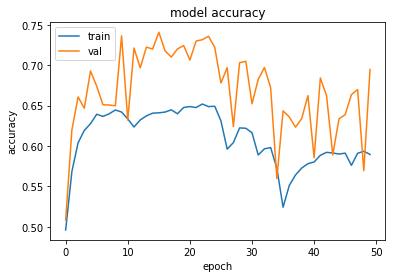

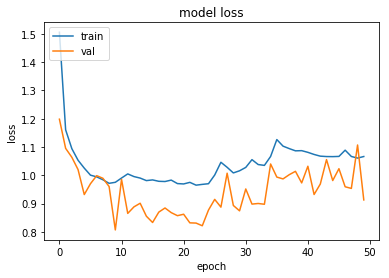

15077/15077 [==============================] - 1s 58us/step
0.8540000462631668 0.6368640976400617
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     10931
           1       0.16      0.82      0.26       274
           2       0.57      0.63      0.59      2755
           3       0.20      0.56      0.29      1117

    accuracy                           0.64     15077
   macro avg       0.47      0.66      0.48     15077
weighted avg       0.80      0.64      0.69     15077

[[7032  634 1213 2052]
 [   4  224    9   37]
 [ 353  289 1724  389]
 [ 102  295   98  622]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.93      0.95     10896
           1       0.75      0.67      0.71       337
           2       0.79      0.88      0.83      2686
           3       0.73      0.75      0.74      1158

    accuracy                           0.90     15077
   macro avg       0.81      0.81      0.81     15077
weighted avg       0.91      0.90      0.90     15077

[[10154    23   510   209]
 [   48   225    21    43]
 [  237    15  2371    63]
 [  140    36   117   865]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 10s 211us/step - loss: 1.4892 - acc: 0.5005 - val_loss: 1.1938 - val_acc: 0.5406
Epoch 2/50
48000/48000 [==============================] - 10s 202us/step - loss: 1.1534 - acc: 0.5827 - val_loss: 1.0577 - val_acc: 0.6488
Epoch 3/50
48000/48000 [==============================] - 10s 202us/step - loss: 1.0626 - acc: 0.6338 - val_loss: 1.0318 - val_a

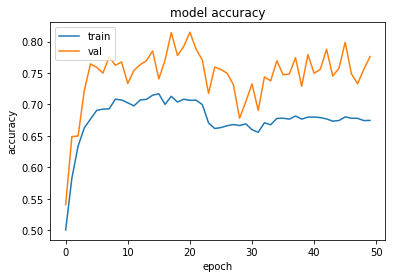

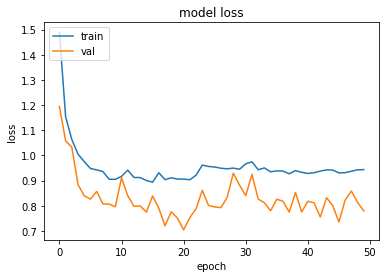

15077/15077 [==============================] - 1s 58us/step
0.7547619540669079 0.7189759235961799
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     10896
           1       0.33      0.75      0.46       337
           2       0.54      0.74      0.63      2686
           3       0.31      0.76      0.44      1158

    accuracy                           0.72     15077
   macro avg       0.54      0.74      0.59     15077
weighted avg       0.84      0.72      0.75     15077

[[7715  234 1530 1417]
 [   3  254   27   53]
 [  40  152 1995  499]
 [  17  126  139  876]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.94      0.95     11001
           1       0.77      0.63      0.69       299
           2       0.78      0.88      0.83      2653
           3       0.75      0.75      0.75      1124

    accuracy                           0.91     15077
   macro avg       0.82      0.80      0.80     15077
weighted avg       0.91      0.91      0.91     15077

[[10288    13   506   194]
 [   43   187    29    40]
 [  248    19  2333    53]
 [  133    23   120   848]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 10s 208us/step - loss: 1.4860 - acc: 0.5140 - val_loss: 1.1571 - val_acc: 0.5928
Epoch 2/50
48000/48000 [==============================] - 9s 196us/step - loss: 1.1418 - acc: 0.5887 - val_loss: 1.0463 - val_acc: 0.6631
Epoch 3/50
48000/48000 [==============================] - 9s 195us/step - loss: 1.0692 - acc: 0.6238 - val_loss: 0.9569 - val_acc

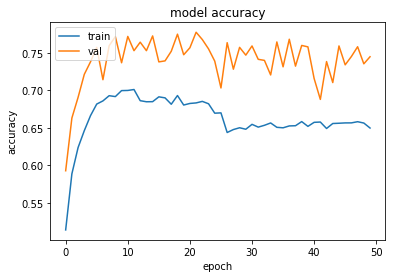

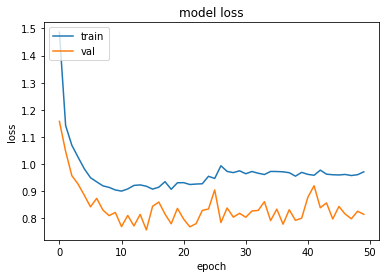

15077/15077 [==============================] - 1s 57us/step
0.7365145575678411 0.7275320023916962
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     11001
           1       0.22      0.81      0.34       299
           2       0.57      0.66      0.61      2653
           3       0.30      0.64      0.41      1124

    accuracy                           0.73     15077
   macro avg       0.52      0.72      0.55     15077
weighted avg       0.84      0.73      0.76     15077

[[8244  448 1170 1139]
 [  10  243   10   36]
 [ 174  238 1761  480]
 [  63  181  159  721]]


In [0]:
# train and test models using cross validation across folds of data
stances = ['unrelated', 'disagree', 'discuss', 'agree']
column_names =  ['Headline', 'Body ID', 'Stance', 'articleBody']
all_data = all_data.sample(frac=1).reset_index(drop=True)
accuracy_scores_rf = []
accuracy_scores_mlp = []
for i in range(5):
  rf = RandomForestClassifier()
  model = build_model(1536)
  kFold_train_df = all_data.iloc[0:0]
  kFold_test_df = all_data.iloc[0:0]
  for j in range(4):
    train_fold = dataset_folds(all_data,((i+j)%5)+1,5)
    kFold_train_df = pd.concat([kFold_train_df,train_fold])
  test_fold = dataset_folds(all_data,((i+4)%5)+1,5)
  kFold_test_df = pd.concat([kFold_test_df,test_fold])
  for stance in stances:
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) == 0):
      continue;              
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) < 15000):
      kFold_train_df = upsample_data(kFold_train_df, str(stance), 15000)
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) > 15000):
      kFold_train_df = downsample_data(kFold_train_df, str(stance), 15000)
  Xtrain = data_processing(kFold_train_df)
  Xtest = data_processing(kFold_test_df)
  Ytrain = kFold_train_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  Ytest = kFold_test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  rf = rf.fit(Xtrain, Ytrain)
  Ypred = rf.predict(Xtest)
  rf_score = accuracy_score(Ytest, Ypred)
  accuracy_scores_rf.append(rf_score)
  print(classification_report(Ytest, Ypred))
  print(confusion_matrix(Ytest, Ypred))
  mlp_score = run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, kFold_test_df)
  accuracy_scores_mlp.append(mlp_score)

In [0]:
from statistics import mean 

print(mean(accuracy_scores_rf))
print(mean(accuracy_scores_mlp))

0.9066127213636664
0.6760098162804009
